# Module

In [1]:
import pandas as pd
import numpy as np
from scipy import sparse
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from lightgbm.callback import early_stopping, log_evaluation
import xgboost as xgb
import optuna
from optuna.samplers import TPESampler
from optuna.integration import LightGBMPruningCallback, XGBoostPruningCallback

# Data

In [2]:
data_path = './data/'

train = pd.read_csv(data_path + 'train.csv', index_col='id')
test = pd.read_csv(data_path + 'test.csv', index_col='id')

submission = pd.read_csv(data_path + 'sample_submission.csv', index_col='id')

print(train.shape, test.shape, submission.shape)

(595212, 58) (892816, 57) (892816, 1)


In [3]:
all_features = train.columns.tolist()
all_features.remove('target')

In [4]:
all_data = pd.concat([train, test], ignore_index=True)
all_data = all_data.drop(columns=['target'])

# Feature Engineering

In [5]:
cat_feautures = [feature for feature in all_features if 'cat' in feature]
cat_feautures

['ps_ind_02_cat',
 'ps_ind_04_cat',
 'ps_ind_05_cat',
 'ps_car_01_cat',
 'ps_car_02_cat',
 'ps_car_03_cat',
 'ps_car_04_cat',
 'ps_car_05_cat',
 'ps_car_06_cat',
 'ps_car_07_cat',
 'ps_car_08_cat',
 'ps_car_09_cat',
 'ps_car_10_cat',
 'ps_car_11_cat']

In [6]:
onehot_encoder = OneHotEncoder()
cat_encoded = onehot_encoder.fit_transform(all_data[cat_feautures])
cat_encoded

<1488028x184 sparse matrix of type '<class 'numpy.float64'>'
	with 20832392 stored elements in Compressed Sparse Row format>

## Derived variables

In [7]:
all_data['num_missing'] = (all_data==-1).sum(axis=1)

In [8]:
all_features.append('num_missing')

In [9]:
remaining_features = [feature for feature in all_features if ('cat' not in feature and 'calc' not in feature)]
remaining_features

['ps_ind_01',
 'ps_ind_03',
 'ps_ind_06_bin',
 'ps_ind_07_bin',
 'ps_ind_08_bin',
 'ps_ind_09_bin',
 'ps_ind_10_bin',
 'ps_ind_11_bin',
 'ps_ind_12_bin',
 'ps_ind_13_bin',
 'ps_ind_14',
 'ps_ind_15',
 'ps_ind_16_bin',
 'ps_ind_17_bin',
 'ps_ind_18_bin',
 'ps_reg_01',
 'ps_reg_02',
 'ps_reg_03',
 'ps_car_11',
 'ps_car_12',
 'ps_car_13',
 'ps_car_14',
 'ps_car_15',
 'num_missing']

In [10]:
ind_features = [feature for feature in all_features if 'ind' in feature]

flag = True
for feature in ind_features:
    if flag:
        all_data['mix_ind'] = all_data[feature].astype('str')
        flag = False
    else:
        all_data['mix_ind'] += '_' + all_data[feature].astype('str')
    
all_data['mix_ind'][:10]

0    2_2_5_1_0_0_1_0_0_0_0_0_0_0_11_0_1_0
1     1_1_7_0_0_0_0_1_0_0_0_0_0_0_3_0_0_1
2    5_4_9_1_0_0_0_1_0_0_0_0_0_0_12_1_0_0
3     0_1_2_0_0_1_0_0_0_0_0_0_0_0_8_1_0_0
4     0_2_0_1_0_1_0_0_0_0_0_0_0_0_9_1_0_0
5     5_1_4_0_0_0_0_0_1_0_0_0_0_0_6_1_0_0
6     2_1_3_1_0_0_1_0_0_0_0_0_0_0_8_1_0_0
7    5_1_4_0_0_1_0_0_0_0_0_0_0_0_13_1_0_0
8     5_1_3_1_0_0_0_1_0_0_0_0_0_0_6_1_0_0
9     1_1_2_0_0_0_1_0_0_0_0_0_0_0_4_0_0_1
Name: mix_ind, dtype: object

In [11]:
count_features = []
for feature in cat_feautures + ['mix_ind']:
    val_counts_dict = all_data[feature].value_counts().to_dict()
    all_data[f'{feature}_count'] = all_data[feature].apply(lambda x: val_counts_dict[x])
    count_features.append(f'{feature}_count')
    
count_features

['ps_ind_02_cat_count',
 'ps_ind_04_cat_count',
 'ps_ind_05_cat_count',
 'ps_car_01_cat_count',
 'ps_car_02_cat_count',
 'ps_car_03_cat_count',
 'ps_car_04_cat_count',
 'ps_car_05_cat_count',
 'ps_car_06_cat_count',
 'ps_car_07_cat_count',
 'ps_car_08_cat_count',
 'ps_car_09_cat_count',
 'ps_car_10_cat_count',
 'ps_car_11_cat_count',
 'mix_ind_count']

## Gathering

In [12]:
drop_features = ['ps_ind_14', 'ps_ind_10_bin', 'ps_ind_11_bin', 
                 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_car_14']

all_data_remaining = all_data[remaining_features+count_features].drop(drop_features, axis=1)
all_data_sprs = sparse.hstack([sparse.csr_matrix(all_data_remaining), cat_encoded], format='csr')
all_data_sprs

<1488028x217 sparse matrix of type '<class 'numpy.float64'>'
	with 61125924 stored elements in Compressed Sparse Row format>

In [13]:
num_train = len(train)

X = all_data_sprs[:num_train]
X_test = all_data_sprs[num_train:]

y = train['target']

# Model

## Optimize Hyperparameters

In [14]:
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2025)

dtrain = lgb.Dataset(x_train, y_train)
dval = lgb.Dataset(x_val, y_val)

In [15]:
def eval_gini(y_true, y_pred):
    assert y_true.shape == y_pred.shape
    n_samples = y_true.shape[0] 
    L_mid = np.linspace(1 / n_samples, 1, n_samples)
    pred_order = y_true[y_pred.argsort()] 
    L_pred = np.cumsum(pred_order) / np.sum(pred_order) 
    G_pred = np.sum(L_mid - L_pred) 
    true_order = y_true[y_true.argsort()] 
    L_true = np.cumsum(true_order) / np.sum(true_order) 
    G_true = np.sum(L_mid - L_true)
    return G_pred / G_true


def gini(preds, dtrain):
    labels = dtrain.get_label()
    return 'gini', eval_gini(labels, preds), True

In [16]:
%%time

def objective_lgbm(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 30, 40),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.7, 0.9),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.9, 1),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 0.7),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 0.9),
        'min_child_samples': trial.suggest_int('min_child_samples', 6, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 10, 40),
        'objective': 'binary',
        'learning_rate': 0.005,
        'bagging_freq': 1,
        'force_row_wise': True,
        'feature_pre_filter': False,
        'random_state': 2025
    }
    
    pruning_callback = LightGBMPruningCallback(trial, 'gini')
    
    lgb_model = lgb.train(
        params=params,
        train_set=dtrain,
        num_boost_round=2500,
        valid_sets=dval,
        feval=gini,
        callbacks=[
            early_stopping(stopping_rounds=300, verbose=False),
            log_evaluation(period=0),
            pruning_callback
        ]
    )
    
    preds = lgb_model.predict(x_val)
    gini_score = eval_gini(y_val.values, preds)
    return gini_score


sampler = TPESampler(seed=2025)
study_lgbm = optuna.create_study(direction='maximize', sampler=sampler)
study_lgbm.optimize(objective_lgbm, n_trials=30)

print(f'Total Trials : {len(study_lgbm.trials)}')
print(f'Best Trial : {study_lgbm.best_trial.number}')
print(f'Best Gini Score : {study_lgbm.best_value:.4f}')
print('Best Parameters :')
for key, value in study_lgbm.best_params.items():
    print(f'{key} : {value}')

[I 2025-11-19 10:24:38,595] A new study created in memory with name: no-name-a7a04898-aba9-44f4-ad8c-c1b3de5247d3


[LightGBM] [Info] Number of positive: 17353, number of negative: 458816
[LightGBM] [Info] Total Bins 1557
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 217
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036443 -> initscore=-3.274884
[LightGBM] [Info] Start training from score -3.274884


[I 2025-11-19 10:27:01,420] Trial 0 finished with value: 0.2797845343383949 and parameters: {'num_leaves': 31, 'lambda_l1': 0.8775703405460756, 'lambda_l2': 0.9932605639886503, 'feature_fraction': 0.6445568164047595, 'bagging_fraction': 0.7164706638341948, 'min_child_samples': 7, 'min_child_weight': 30}. Best is trial 0 with value: 0.2797845343383949.


[LightGBM] [Info] Number of positive: 17353, number of negative: 458816
[LightGBM] [Info] Total Bins 1557
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 217
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036443 -> initscore=-3.274884
[LightGBM] [Info] Start training from score -3.274884


[I 2025-11-19 10:29:10,423] Trial 1 finished with value: 0.2779833062079669 and parameters: {'num_leaves': 35, 'lambda_l1': 0.8928476838500115, 'lambda_l2': 0.980098447486944, 'feature_fraction': 0.6455205285209574, 'bagging_fraction': 0.8403174259775985, 'min_child_samples': 6, 'min_child_weight': 33}. Best is trial 0 with value: 0.2797845343383949.


[LightGBM] [Info] Number of positive: 17353, number of negative: 458816
[LightGBM] [Info] Total Bins 1557
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 217
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036443 -> initscore=-3.274884
[LightGBM] [Info] Start training from score -3.274884


[I 2025-11-19 10:31:16,449] Trial 2 finished with value: 0.2790675737640848 and parameters: {'num_leaves': 30, 'lambda_l1': 0.7585618784098953, 'lambda_l2': 0.9610914332666879, 'feature_fraction': 0.6913027391420645, 'bagging_fraction': 0.690034501423391, 'min_child_samples': 7, 'min_child_weight': 30}. Best is trial 0 with value: 0.2797845343383949.


[LightGBM] [Info] Number of positive: 17353, number of negative: 458816
[LightGBM] [Info] Total Bins 1557
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 217
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036443 -> initscore=-3.274884
[LightGBM] [Info] Start training from score -3.274884


[I 2025-11-19 10:33:25,669] Trial 3 finished with value: 0.27806086463665874 and parameters: {'num_leaves': 40, 'lambda_l1': 0.7936540812148857, 'lambda_l2': 0.9123287379526355, 'feature_fraction': 0.6916031386732439, 'bagging_fraction': 0.8838430600450276, 'min_child_samples': 7, 'min_child_weight': 26}. Best is trial 0 with value: 0.2797845343383949.


[LightGBM] [Info] Number of positive: 17353, number of negative: 458816
[LightGBM] [Info] Total Bins 1557
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 217
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036443 -> initscore=-3.274884
[LightGBM] [Info] Start training from score -3.274884


[I 2025-11-19 10:35:33,468] Trial 4 finished with value: 0.2776771775589265 and parameters: {'num_leaves': 31, 'lambda_l1': 0.702925470564844, 'lambda_l2': 0.9324243206409492, 'feature_fraction': 0.6990898438745787, 'bagging_fraction': 0.7539423863417978, 'min_child_samples': 10, 'min_child_weight': 12}. Best is trial 0 with value: 0.2797845343383949.
[I 2025-11-19 10:35:33,662] Trial 5 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Number of positive: 17353, number of negative: 458816
[LightGBM] [Info] Total Bins 1557
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 217
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036443 -> initscore=-3.274884
[LightGBM] [Info] Start training from score -3.274884
[LightGBM] [Info] Number of positive: 17353, number of negative: 458816


[I 2025-11-19 10:35:33,880] Trial 6 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Total Bins 1557
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 217
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036443 -> initscore=-3.274884
[LightGBM] [Info] Start training from score -3.274884
[LightGBM] [Info] Number of positive: 17353, number of negative: 458816


[I 2025-11-19 10:35:34,122] Trial 7 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Total Bins 1557
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 217
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036443 -> initscore=-3.274884
[LightGBM] [Info] Start training from score -3.274884
[LightGBM] [Info] Number of positive: 17353, number of negative: 458816


[I 2025-11-19 10:35:34,403] Trial 8 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Total Bins 1557
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 217
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036443 -> initscore=-3.274884
[LightGBM] [Info] Start training from score -3.274884
[LightGBM] [Info] Number of positive: 17353, number of negative: 458816


[I 2025-11-19 10:35:34,632] Trial 9 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Total Bins 1557
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 217
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036443 -> initscore=-3.274884
[LightGBM] [Info] Start training from score -3.274884
[LightGBM] [Info] Number of positive: 17353, number of negative: 458816


[I 2025-11-19 10:35:34,862] Trial 10 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Total Bins 1557
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 217
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036443 -> initscore=-3.274884
[LightGBM] [Info] Start training from score -3.274884
[LightGBM] [Info] Number of positive: 17353, number of negative: 458816


[I 2025-11-19 10:35:35,082] Trial 11 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Total Bins 1557
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 217
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036443 -> initscore=-3.274884
[LightGBM] [Info] Start training from score -3.274884
[LightGBM] [Info] Number of positive: 17353, number of negative: 458816


[I 2025-11-19 10:35:35,316] Trial 12 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Total Bins 1557
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 217
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036443 -> initscore=-3.274884
[LightGBM] [Info] Start training from score -3.274884
[LightGBM] [Info] Number of positive: 17353, number of negative: 458816


[I 2025-11-19 10:35:35,565] Trial 13 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Total Bins 1557
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 217
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036443 -> initscore=-3.274884
[LightGBM] [Info] Start training from score -3.274884
[LightGBM] [Info] Number of positive: 17353, number of negative: 458816


[I 2025-11-19 10:35:35,819] Trial 14 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Total Bins 1557
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 217
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036443 -> initscore=-3.274884
[LightGBM] [Info] Start training from score -3.274884
[LightGBM] [Info] Number of positive: 17353, number of negative: 458816


[I 2025-11-19 10:35:36,070] Trial 15 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Total Bins 1557
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 217
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036443 -> initscore=-3.274884
[LightGBM] [Info] Start training from score -3.274884
[LightGBM] [Info] Number of positive: 17353, number of negative: 458816


[I 2025-11-19 10:35:36,359] Trial 16 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Total Bins 1557
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 217
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036443 -> initscore=-3.274884
[LightGBM] [Info] Start training from score -3.274884
[LightGBM] [Info] Number of positive: 17353, number of negative: 458816
[LightGBM] [Info] Total Bins 1557
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 217
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036443 -> initscore=-3.274884
[LightGBM] [Info] Start training from score -3.274884


[I 2025-11-19 10:35:37,907] Trial 17 pruned. Trial was pruned at iteration 24.
[I 2025-11-19 10:35:38,114] Trial 18 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Number of positive: 17353, number of negative: 458816
[LightGBM] [Info] Total Bins 1557
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 217
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036443 -> initscore=-3.274884
[LightGBM] [Info] Start training from score -3.274884
[LightGBM] [Info] Number of positive: 17353, number of negative: 458816
[LightGBM] [Info] Total Bins 1557
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 217
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036443 -> initscore=-3.274884
[LightGBM] [Info] Start training from score -3.274884


[I 2025-11-19 10:35:38,380] Trial 19 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Number of positive: 17353, number of negative: 458816
[LightGBM] [Info] Total Bins 1557
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 217
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036443 -> initscore=-3.274884
[LightGBM] [Info] Start training from score -3.274884


[I 2025-11-19 10:35:38,639] Trial 20 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Number of positive: 17353, number of negative: 458816
[LightGBM] [Info] Total Bins 1557
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 217
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036443 -> initscore=-3.274884
[LightGBM] [Info] Start training from score -3.274884


[I 2025-11-19 10:35:40,322] Trial 21 pruned. Trial was pruned at iteration 25.


[LightGBM] [Info] Number of positive: 17353, number of negative: 458816
[LightGBM] [Info] Total Bins 1557
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 217
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036443 -> initscore=-3.274884
[LightGBM] [Info] Start training from score -3.274884


[I 2025-11-19 10:35:40,579] Trial 22 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Number of positive: 17353, number of negative: 458816
[LightGBM] [Info] Total Bins 1557
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 217
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036443 -> initscore=-3.274884
[LightGBM] [Info] Start training from score -3.274884


[I 2025-11-19 10:35:40,872] Trial 23 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 17353, number of negative: 458816


[I 2025-11-19 10:35:41,333] Trial 24 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Total Bins 1557
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 217
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036443 -> initscore=-3.274884
[LightGBM] [Info] Start training from score -3.274884
[LightGBM] [Info] Number of positive: 17353, number of negative: 458816


[I 2025-11-19 10:35:41,696] Trial 25 pruned. Trial was pruned at iteration 0.


[LightGBM] [Info] Total Bins 1557
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 217
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036443 -> initscore=-3.274884
[LightGBM] [Info] Start training from score -3.274884
[LightGBM] [Info] Number of positive: 17353, number of negative: 458816


[I 2025-11-19 10:35:41,972] Trial 26 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Total Bins 1557
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 217
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036443 -> initscore=-3.274884
[LightGBM] [Info] Start training from score -3.274884
[LightGBM] [Info] Number of positive: 17353, number of negative: 458816
[LightGBM] [Info] Total Bins 1557
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 217
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036443 -> initscore=-3.274884
[LightGBM] [Info] Start training from score -3.274884


[I 2025-11-19 10:35:44,063] Trial 27 pruned. Trial was pruned at iteration 32.


[LightGBM] [Info] Number of positive: 17353, number of negative: 458816
[LightGBM] [Info] Total Bins 1557
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 217
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036443 -> initscore=-3.274884
[LightGBM] [Info] Start training from score -3.274884


[I 2025-11-19 10:35:44,346] Trial 28 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 17353, number of negative: 458816
[LightGBM] [Info] Total Bins 1557
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 217
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036443 -> initscore=-3.274884
[LightGBM] [Info] Start training from score -3.274884


[I 2025-11-19 10:35:44,657] Trial 29 pruned. Trial was pruned at iteration 1.


Total Trials : 30
Best Trial : 0
Best Gini Score : 0.2798
Best Parameters :
num_leaves : 31
lambda_l1 : 0.8775703405460756
lambda_l2 : 0.9932605639886503
feature_fraction : 0.6445568164047595
bagging_fraction : 0.7164706638341948
min_child_samples : 7
min_child_weight : 30
CPU times: user 37min 7s, sys: 5.26 s, total: 37min 12s
Wall time: 11min 6s


In [18]:
fixed_params = {
    'objective': 'binary',
    'learning_rate': 0.005,
    'bagging_freq': 1,
    'force_row_wise': True,
    'feature_pre_filter': False,
    'random_state': 2025
}

final_params = {**fixed_params, **study_lgbm.best_params}
final_params

{'objective': 'binary',
 'learning_rate': 0.005,
 'bagging_freq': 1,
 'force_row_wise': True,
 'feature_pre_filter': False,
 'random_state': 2025,
 'num_leaves': 31,
 'lambda_l1': 0.8775703405460756,
 'lambda_l2': 0.9932605639886503,
 'feature_fraction': 0.6445568164047595,
 'bagging_fraction': 0.7164706638341948,
 'min_child_samples': 7,
 'min_child_weight': 30}

In [19]:
%%time

folds = StratifiedKFold(n_splits=5, random_state=2025, shuffle=True)

oof_val_preds_lgbm = np.zeros(X.shape[0])
oof_test_preds_lgbm = np.zeros(X_test.shape[0])

for idx, (train_idx, val_idx) in enumerate(folds.split(X, y)):
    print('#'*40, f'Fold {idx + 1}/{folds.n_splits}', '#'*40)
    x_train, y_train = X[train_idx], y.iloc[train_idx]
    x_val, y_val = X[val_idx], y.iloc[val_idx]
    
    dtrain = lgb.Dataset(x_train, y_train)
    dval = lgb.Dataset(x_val, y_val)
    
    lgb_model = lgb.train(
        params=final_params,
        train_set=dtrain,
        num_boost_round=2500,
        valid_sets=dval,
        feval=gini,
        callbacks=[
            early_stopping(stopping_rounds=300, verbose=False),
            log_evaluation(period=0)
        ]
    )
    
    oof_test_preds_lgbm += lgb_model.predict(X_test) / folds.n_splits
    oof_val_preds_lgbm[val_idx] = lgb_model.predict(x_val)
    
    gini_score = eval_gini(y_val.values, oof_val_preds_lgbm[val_idx])
    print(f'Fold {idx + 1}/{folds.n_splits} Gini: {gini_score}')

######################################## Fold 1/5 ########################################
[LightGBM] [Info] Number of positive: 17355, number of negative: 458814
[LightGBM] [Info] Total Bins 1557
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 217
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274764
[LightGBM] [Info] Start training from score -3.274764
Fold 1/5 Gini: 0.2788677377190358
######################################## Fold 2/5 ########################################
[LightGBM] [Info] Number of positive: 17355, number of negative: 458814
[LightGBM] [Info] Total Bins 1557
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 217
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274764
[LightGBM] [Info] Start training from score -3.274764
Fold 2/5 Gini: 0.2817122145806455
######################################## Fold 3/5 ##############################

In [20]:
print(f'Final OOF Gini Score: {eval_gini(y.values, oof_val_preds_lgbm):.4f}')

Final OOF Gini Score: 0.2889


- Baseline 모델 점수(0.2813)보다 향상됨

# Submission

In [21]:
submission['target'] = oof_test_preds_lgbm
submission.head()

,target
id,
0,0.027515
1,0.023157
2,0.023886
3,0.014242
4,0.037925


In [22]:
submission.to_csv(data_path + 'lgbm_submission.csv')

In [46]:
!chmod 600 /teamspace/studios/this_studio/.kaggle/kaggle.json
!kaggle competitions submit -c porto-seguro-safe-driver-prediction -f "./data/lgbm_submission.csv" -m "03_Emprovments_lgbm"

100%|██████████████████████████████████████| 23.5M/23.5M [00:00<00:00, 33.9MB/s]
Successfully submitted to Porto Seguro’s Safe Driver Prediction

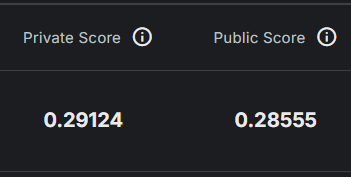

# Model - Xgb

In [23]:
def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    return 'gini', eval_gini(labels, preds)

In [24]:
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2025)

dtrain = xgb.DMatrix(x_train, y_train)
dval = xgb.DMatrix(x_val, y_val)

In [25]:
%%time

fixed_params = {
    'objective': 'binary:logistic',
    'learning_rate': 0.02,
    'random_state': 2025
}

def objective_xgb(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 4, 8),
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 5, 7),
        'gamma': trial.suggest_int('gamma', 8, 11),
        'reg_alpha': trial.suggest_int('reg_alpha', 7, 9),
        'reg_lambda': trial.suggest_float('reg_lambda', 1.1, 1.5),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.4, 1.6),
        **fixed_params
    }
    
    pruning_callback = XGBoostPruningCallback(trial, "eval-gini")
    
    xgb_model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=2000,
        evals=[(dval, 'eval')],
        custom_metric=gini_xgb,
        maximize=True,
        early_stopping_rounds=300,
        verbose_eval=False,
        callbacks=[pruning_callback]
    )
    
    preds = xgb_model.predict(dval)
    gini_score = eval_gini(y_val.values, preds)
    return gini_score


sampler = TPESampler(seed=2025)
study_xgb = optuna.create_study(direction='maximize', sampler=sampler)
study_xgb.optimize(objective_xgb, n_trials=30)

print(f'Total Trials : {len(study_xgb.trials)}')
print(f'Best Trial : {study_xgb.best_trial.number}')
print(f'Best Gini Score : {study_xgb.best_value:.4f}')
print('Best Parameters :')
for key, value in study_xgb.best_params.items():
    print(f'{key} : {value}')

[I 2025-11-19 10:54:55,401] A new study created in memory with name: no-name-f386c277-b851-4841-b66c-30b6d50700a4
[I 2025-11-19 10:56:06,974] Trial 0 finished with value: 0.2705729837486674 and parameters: {'max_depth': 4, 'subsample': 0.8663555108191134, 'colsample_bytree': 0.9797816919659508, 'min_child_weight': 6, 'gamma': 9, 'reg_alpha': 7, 'reg_lambda': 1.3629470341884151, 'scale_pos_weight': 1.4985233875012525}. Best is trial 0 with value: 0.2705729837486674.
[I 2025-11-19 10:57:20,424] Trial 1 finished with value: 0.27285452866934734 and parameters: {'max_depth': 8, 'subsample': 0.840295342460832, 'colsample_bytree': 0.8365615855628724, 'min_child_weight': 7, 'gamma': 8, 'reg_alpha': 9, 'reg_lambda': 1.1012684467021179, 'scale_pos_weight': 1.4585618784098953}. Best is trial 1 with value: 0.27285452866934734.
[I 2025-11-19 10:58:13,134] Trial 2 finished with value: 0.2699102927859403 and parameters: {'max_depth': 7, 'subsample': 0.8739082174261938, 'colsample_bytree': 0.790034501

Total Trials : 30
Best Trial : 3
Best Gini Score : 0.2737
Best Parameters :
max_depth : 8
subsample : 0.8838430600450276
colsample_bytree : 0.7833092119912622
min_child_weight : 6
gamma : 8
reg_alpha : 7
reg_lambda : 1.2296972825637966
scale_pos_weight : 1.5981796877491576
CPU times: user 27min 45s, sys: 3.24 s, total: 27min 48s
Wall time: 8min 52s


In [26]:
final_params = {**fixed_params, **study_xgb.best_params}
final_params

{'objective': 'binary:logistic',
 'learning_rate': 0.02,
 'random_state': 2025,
 'max_depth': 8,
 'subsample': 0.8838430600450276,
 'colsample_bytree': 0.7833092119912622,
 'min_child_weight': 6,
 'gamma': 8,
 'reg_alpha': 7,
 'reg_lambda': 1.2296972825637966,
 'scale_pos_weight': 1.5981796877491576}

In [27]:
folds = StratifiedKFold(n_splits=5, random_state=2025, shuffle=True)

oof_val_preds_xgb = np.zeros(X.shape[0])
oof_test_preds_xgb = np.zeros(X_test.shape[0])
dtest = xgb.DMatrix(X_test)

for idx, (train_idx, val_idx) in enumerate(folds.split(X, y)):
    print('#'*40, f'Fold {idx + 1}/{folds.n_splits}', '#'*40)
    x_train, y_train = X[train_idx], y.iloc[train_idx]
    x_val, y_val = X[val_idx], y.iloc[val_idx]
    
    dtrain = xgb.DMatrix(x_train, y_train)
    dval = xgb.DMatrix(x_val, y_val)
    
    xgb_model = xgb.train(
        params=final_params,
        dtrain=dtrain,
        num_boost_round=2000,
        evals=[(dval, 'eval')],
        custom_metric=gini_xgb,
        maximize=True,
        early_stopping_rounds=300,
        verbose_eval=100
    )
    
    oof_test_preds_xgb += xgb_model.predict(dtest) / folds.n_splits
    oof_val_preds_xgb[val_idx] = xgb_model.predict(dval)
    
    gini_score = eval_gini(y_val.values, oof_val_preds_xgb[val_idx])
    print(f'Fold {idx + 1}/{folds.n_splits} Gini: {gini_score}')

print('#'*40)
print(f'Final OOF Gini Score: {eval_gini(y.values, oof_val_preds_xgb):.4f}')

######################################## Fold 1/5 ########################################
[0]	eval-logloss:0.22000	eval-gini:0.20261
[100]	eval-logloss:0.16267	eval-gini:0.26083
[200]	eval-logloss:0.15726	eval-gini:0.27060
[300]	eval-logloss:0.15655	eval-gini:0.27366
[400]	eval-logloss:0.15646	eval-gini:0.27406
[500]	eval-logloss:0.15647	eval-gini:0.27418
[600]	eval-logloss:0.15645	eval-gini:0.27418
[700]	eval-logloss:0.15646	eval-gini:0.27430
[800]	eval-logloss:0.15645	eval-gini:0.27433
[900]	eval-logloss:0.15645	eval-gini:0.27436
[1000]	eval-logloss:0.15644	eval-gini:0.27448
[1100]	eval-logloss:0.15645	eval-gini:0.27447
[1200]	eval-logloss:0.15644	eval-gini:0.27448
[1280]	eval-logloss:0.15644	eval-gini:0.27448
Fold 1/5 Gini: 0.27447868182034313
######################################## Fold 2/5 ########################################
[0]	eval-logloss:0.22000	eval-gini:0.19611
[100]	eval-logloss:0.16270	eval-gini:0.26199
[200]	eval-logloss:0.15731	eval-gini:0.27194
[300]	eval-logloss

- Baseline : 0.2813, LGBM : 0.2889, XGB : 0.2840

# Ensemble

In [28]:
oof_test_preds = 0.5 * oof_test_preds_lgbm + 0.5 * oof_test_preds_xgb

In [29]:
submission['target'] = oof_test_preds
submission.head()

,target
id,
0,0.034702
1,0.031363
2,0.032481
3,0.019037
4,0.048078


In [30]:
submission.to_csv(data_path + 'submission_ensemble.csv')

In [31]:
!chmod 600 /teamspace/studios/this_studio/.kaggle/kaggle.json
!kaggle competitions submit -c porto-seguro-safe-driver-prediction -f "./data/submission_ensemble.csv" -m "03_Emprovments_ensemble"

100%|██████████████████████████████████████| 23.4M/23.4M [00:00<00:00, 36.2MB/s]
Successfully submitted to Porto Seguro’s Safe Driver Prediction

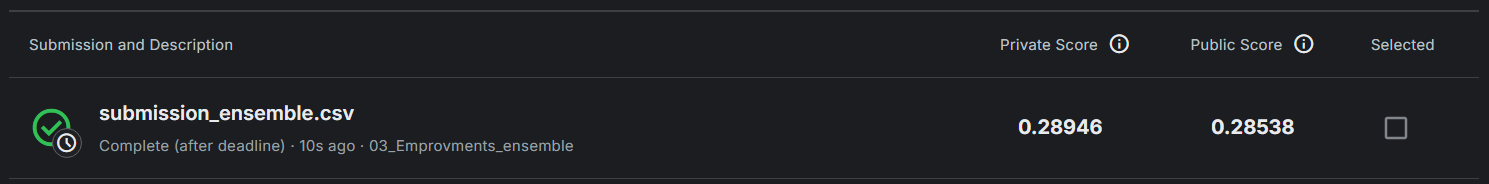

- LGBM 모델의 성능이 가장 높게 측정됨
    - 29 / 5157